# Trump Twitter EDA

### In this project, I analyze approximately 2 1/2 years' worth of Donald Trump's tweets, performing EDA and sentiment analysis to answer some questions regarding his tweeting behavior, such as: 
#### - Can we guess, based on time of day and the device from which a tweet is posted, whether the tweet came from Trump himself or from his PR staff? 
#### - What are Trump's most positive/most negative tweets? 
#### - Are there any buzzwords that are indicative of how widely retweeted a tweet will be? 
#### - Can we identify factors that are correlated with sentiment of tweets?

In [1]:
import numpy as np
import pandas as pd

# Want to see full tweets in dataframe
pd.set_option('max_colwidth', 280)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set()
sns.set_context("talk")

import json
import tweepy
from pathlib import Path

In [2]:
# Load Twitter API keys
key_file = 'keys.json'
with open(key_file) as f:
    keys = json.load(f)

In [3]:
# Authenticate Twitter account
auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
auth.set_access_token(keys["access_token"], keys["access_token_secret"])
api = tweepy.API(auth)

In [4]:
# The Twitter API only lets you download the last ~3,200
# tweets from a given user. The following functions are
# designed to facilitate the process of downloading all
# available tweets at intervals and merging the resulting lists.

def download_tweets(user_account_name):
    """Downloads all available tweets from a user
    Input:
        user_account_name (str) - the user's twitter handle, without the @"""
    
    tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]
    print("Number of tweets downloaded:", len(tweets))
    return tweets

def save_tweets(tweets, path):
    """Saves a list of tweets to a file
    Inputs:
        tweets (list) - list of tweet objects of type dict
        path (str) - file where to save the tweets"""
    
    with open(path, 'w') as f:
        json.dump(tweets, f)
        
def load_tweets(path):
    """Loads tweets from a file; if no such file exists, returns an empty list
    Input:
        path (str) - file to load the tweets from"""
    
    if Path(path).is_file():
        with open(path, 'r') as f:
            tweets = json.load(f)
        return tweets
    else:
        return []

def merge_tweets(old_tweets, new_tweets):
    """Merges two lists of tweets, eliminating duplicates
    Inputs:
        old_tweets (list) - list of tweet objects of type dict
        new_tweets (list) - same"""
    
    tweets = {tweet['id']: tweet for tweet in old_tweets}
    tweets.update({tweet['id']: tweet for tweet in new_tweets})
    tweets = list(tweets.values())
    return tweets

def update_tweets(user_account_name, path, overwrite=False):
    """Downloads all available tweets from a user and merges them
    with a list of previously downloaded tweets. Optionally overwrites
    the file containing the previously downloaded tweets with the
    merged list of tweets
    
    Inputs:
        user_account_name (str) - the user's twitter handle, without the @
        path (str) - file to load the tweets from and (optionally) save the updated list to
        overwrite (bool) - solely used to prevent accidental overwriting"""
    
    old_tweets = load_tweets(path)
    new_tweets = download_tweets(user_account_name)
    all_tweets = merge_tweets(old_tweets, new_tweets)
    if overwrite:
        save_tweets(all_tweets, path)
    return all_tweets

In [5]:
# Load our previously downloaded tweets
trump_tweets = load_tweets('trump_tweets.json')
print('Number of tweets:', len(trump_tweets))

Number of tweets: 8113


In [6]:
# Inspect a sample tweet
trump_tweets[0]

{'created_at': 'Fri Jul 27 16:20:37 +0000 2018',
 'id': 1022879441767288834,
 'id_str': '1022879441767288834',
 'full_text': 'We have accomplished an economic turnaround of HISTORIC proportions! https://t.co/vnmMtPv0kk',
 'truncated': False,
 'display_text_range': [0, 68],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 1022878988513898496,
    'id_str': '1022878988513898496',
    'indices': [69, 92],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/1022878988513898496/pu/img/XDHoi2ZKtPgCKEYg.jpg',
    'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/1022878988513898496/pu/img/XDHoi2ZKtPgCKEYg.jpg',
    'url': 'https://t.co/vnmMtPv0kk',
    'display_url': 'pic.twitter.com/vnmMtPv0kk',
    'expanded_url': 'https://twitter.com/realDonaldTrump/status/1022879441767288834/video/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 1200, 'h': 675, 'resize': 'fit'

In [7]:
# Load trump_tweets into DataFrame. Note that the 
# text of the tweets is stored in either the 'text'
# or 'full_text' field (but never both)
columns = (
    ['id', 'created_at', 'source', 'text', 
     'full_text', 'retweet_count', 'retweeted_status']
)

trump = (
    pd.DataFrame(data=trump_tweets, columns=columns)
    .rename(columns={'created_at': 'time'})
    .set_index('id')
    .sort_index()
)

# Convert 'time' column to datetime objects
trump['time'] = pd.to_datetime(trump['time'])

# Ensure each row has text in exactly one of 'text', 'full_text' cols.
assert sum(
    (trump['text'].isnull() & trump['full_text'].isnull())
    | (~trump['text'].isnull() & ~trump['full_text'].isnull())
) == 0

# Combine 'text' and 'full_text' cols
trump['text'] = trump['text'].fillna('') + trump['full_text'].fillna('')

# Say whether each tweet in 'trump' is a retweet
trump['is_retweet'] = ~trump['retweeted_status'].isna()

# Drop 'full_text' and 'retweeted_status' cols
trump.drop(columns=['full_text', 'retweeted_status'], inplace=True)

trump.head()

,time,source,text,retweet_count,is_retweet
id,,,,,
690171032150237184,2016-01-21 13:56:11,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,False
690171403388104704,2016-01-21 13:57:39,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,False
690173226341691392,2016-01-21 14:04:54,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,False
690176882055114758,2016-01-21 14:19:26,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,False
690180284189310976,2016-01-21 14:32:57,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,False


In [8]:
# Get range of dates in our list of tweets
first_tweet = min(trump['time']).strftime('%m/%d/%Y')
last_tweet = max(trump['time']).strftime('%m/%d/%Y')

print(f'The earliest tweet in our list is from {first_tweet}, '
      f'and the most recent is from {last_tweet}.')

The earliest tweet in our list is from 01/21/2016, and the most recent is from 07/27/2018.


#### First, let's look into which devices Trump most often tweets from and what information can be derived from that:

In [9]:
# List all unique devices of origin
trump['source'].unique()

array(['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>'],
      dtype=object)

In [10]:
# Remove HTML tags
trump['source'] = trump['source'].str.replace(pat=r'<.*?>', repl='')

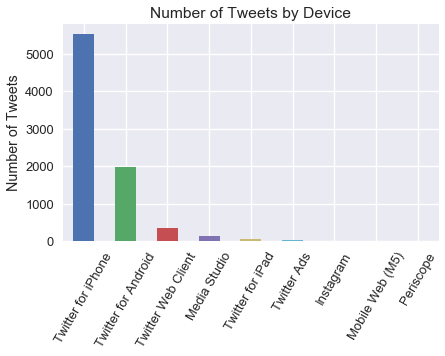

In [11]:
# Plot counts of tweets by device of origin
trump['source'].value_counts().plot(kind="bar")
plt.xticks(rotation=60)
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Device');

In [12]:
# Since Trump is likely to be tweeting from either New York
# or Washington DC, we convert timezone to EST.
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)

# Convert 'est_time' to float btwn 0 and 24
trump['hour'] = trump['est_time'].apply(lambda t: t.hour + t.minute / 60 + t.second / 3600)

/Users/efscerbo/anaconda3/envs/data100/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


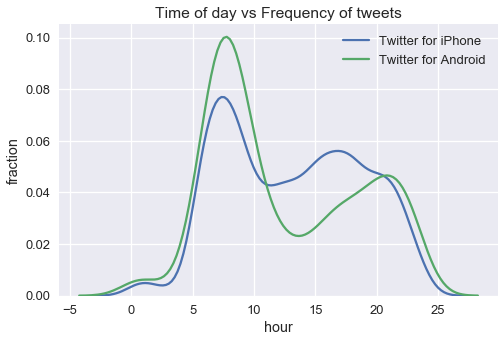

In [13]:
# Plot time-of-day distribution for tweets coming 
# from most commonly used devices
plt.figure(figsize=(7, 5))
for i in range(2):
    device = trump['source'].value_counts().index[i]
    sns.distplot(trump[trump['source'] == device]['hour'], hist=False, label=device)
plt.ylabel('fraction')
plt.title('Time of day vs Frequency of tweets')
plt.legend();

#### We notice that Trump's tweets from the Android are mostly concentrated in the early morning and have a smaller peak at night. His tweets from the iPhone are more evenly distributed throughout the day. It's not entirely clear what this means, but perhaps it's the case that his personal device is the Android, and he personally tweets mostly in the morning and a bit at night, whereas the tweets from the iPhone are from his PR team? Not clear, but this is not an unreasonable hypothesis at the moment.

In [14]:
# Convert year to float for plotting
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

trump['year'] = trump['time'].apply(year_fraction)

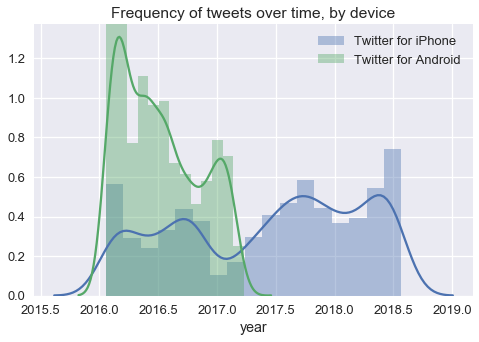

In [15]:
# Plot distribution of tweets over time for two most commonly used devices
plt.figure(figsize=(7, 5))
for i in range(2):
    device = trump['source'].value_counts().index[i]
    sns.distplot(trump[trump['source'] == device]['year'], label=device)
plt.title('Frequency of tweets over time, by device')
plt.legend();

#### This graph correlates very well with media articles from early 2017 reporting that Trump was giving up his Android for an iPhone because of security concerns:

https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android

#### This contradicts our above speculation that the Android was his personal device. Let's inspect this a bit more:

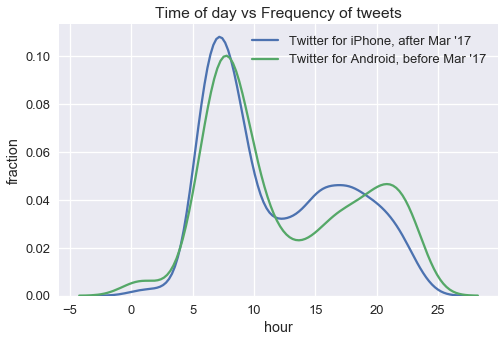

In [16]:
# The above linked article, published on 03/29/17, says that
# Trump made the switch a couple weeks earlier. Let's compare
# his tweeting behavior from the Android before, say, 03/15/17,
# with his tweeting behavior from the iPhone after that date.
mid_march = pd.Timestamp('20170315')
early_trump_android = (
    trump[(trump['time'] <= mid_march) & 
          (trump['source'] == 'Twitter for Android')]
)
late_trump_iphone = (
    trump[(trump['time'] > mid_march) & 
          (trump['source'] == 'Twitter for iPhone')]
)

plt.figure(figsize=(7, 5))
sns.distplot(late_trump_iphone['hour'], hist=False, label='Twitter for iPhone, after Mar \'17')
sns.distplot(early_trump_android['hour'], hist=False, label='Twitter for Android, before Mar \'17')
plt.ylabel('fraction')
plt.title('Time of day vs Frequency of tweets')
plt.legend();

#### These graphs are strikingly similar. On the strength of the foregoing, I would certainly guess that nowadays, any tweets posted to his account in early morning or late evening from an iPhone are coming from him, personally. Tweets at other times of day or from other devices may well be his PR staff.

### Let's shift gears and use the VADER lexicon to identify Trump's most negative and most positive tweets:

In [17]:
# Import VADER lexicon into DataFrame
sent = pd.read_csv("vader_lexicon.txt", sep='\t', 
                   usecols=[0, 1], header=None, names=['token', 'polarity'], 
                   index_col='token')
sent.head()

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [18]:
# Make text of tweets all lowercase and remove all
# punctuation from tweets (keep original)
trump['text'] = trump['text'].str.lower()
trump['no_punc'] = trump['text'].str.replace(pat=r'[^\w\s]', repl=' ')

In [19]:
# Put text of tweets into "tidy format", i.e., each word of each
# tweet gets put into its own row, indexed by id of tweet
tidy_format = (
    trump['no_punc']
    .str.split(expand=True)
    .stack()
    .reset_index(level=1)
    .rename(columns={'level_1': 'num', 0: 'word'})
)

tidy_format.head(10)

,num,word
id,,
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t
690171032150237184,5,co
690171032150237184,6,3kyqgqevyd
690171403388104704,0,americanaspie
690171403388104704,1,glennbeck


In [20]:
# Assign sentiment value to each tweet by summing 
# polarity of each word in tweet
trump['polarity'] = (
    tidy_format
    .merge(sent, how='left', left_on='word', right_index=True)
    #.fillna(0) # seems sum() treats NaNs as 0's, but if any errors happen, uncomment
    .groupby('id')['polarity']
    .sum()
)

In [21]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   james comey is a proven leaker &amp; liar. virtually everyone in washington thought he should be fired for the terrible job he did-until he was, in fact, fired. he leaked classified information, for which he should be prosecuted. he lied to congress under oath. he is a weak and.....

   ....,the only collusion with russia was with the democrats, so now they are looking at my tweets (along with 53 million other people) - the rigged witch hunt continues! how stupid and unfair to our country....and so the fake news doesn’t waste my time with dumb questions, no,....

   horrible and cowardly terrorist attack on innocent and defenseless worshipers in egypt. the world cannot tolerate terrorism, we must defeat them militarily and discredit the extremist ideology that forms the basis of their existence!

   our thoughts and prayers are with the victims of the horrible attack in france yesterday, and we grieve the nation’s loss. we also condemn the violent actions of t

In [22]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!

   thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier classic – salute to service dinner” in west virginia! god bless ou

### Next, let's identify words that appear in Trump's most retweeted tweets:

In [23]:
# Filter out words that do not appear in at least 25
# different tweets. Then, for each word, compute the
# median number of retweets of all tweets containing that word.
top_20 = (
    tidy_format
    .groupby('word')
    .filter(lambda x: x.index.nunique() >= 25)
    .merge(trump, how='left', left_index=True, right_index=True)
    .groupby('word')[['retweet_count']]
    .median()
    .sort_values('retweet_count', ascending=False)
    .head(20)
)

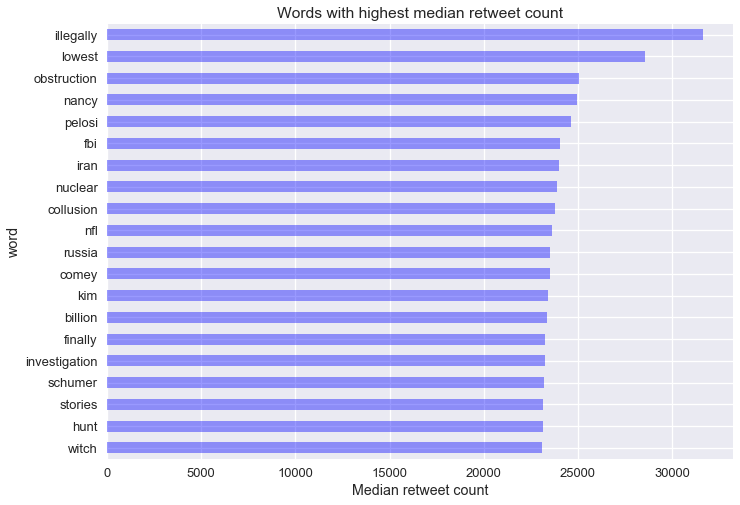

In [24]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8), facecolor='b', alpha=0.4)
plt.xlabel('Median retweet count')
plt.title('Words with highest median retweet count');

### Next, we examine the sentiment of those of Trump's tweets mentioning NYTimes as compared to those mentioning Fox News:

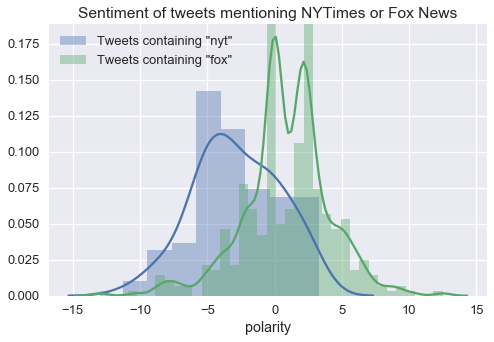

In [25]:
# Plot distribution of sentiment of tweets containing " nyt"
# or " fox" as substrings
nyt = trump[trump['no_punc'].str.contains(' nyt')]
fox = trump[trump['no_punc'].str.contains(' fox')]

plt.figure(figsize=(7, 5))
sns.distplot(nyt['polarity'], label='Tweets containing "nyt"')
sns.distplot(fox['polarity'], label='Tweets containing "fox"')
plt.title('Sentiment of tweets mentioning NYTimes or Fox News')
plt.legend();

#### Unsurprisingly, tweets mentioning Fox News are more positive on average than those mentioning NYTimes. Let's inspect this a bit further:

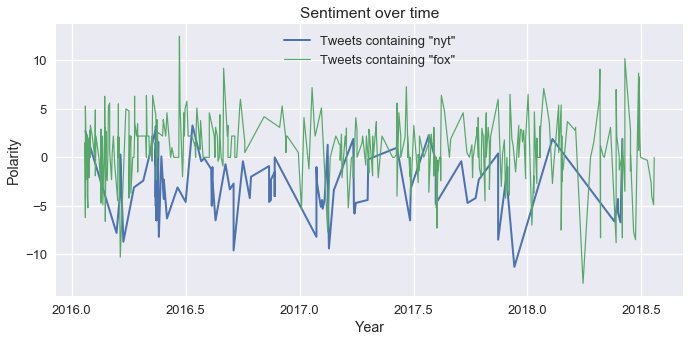

In [26]:
# Does the sentiment of tweets mentioning Fox News or
# NYTimes change over time?
plt.figure(figsize=(10, 5))
plt.plot(nyt.set_index('year').sort_index()['polarity'], linewidth=2, label='Tweets containing "nyt"')
plt.plot(fox.set_index('year').sort_index()['polarity'], linewidth=1.2, label='Tweets containing "fox"')
plt.xlabel('Year')
plt.ylabel('Polarity')
plt.title('Sentiment over time')
plt.legend();

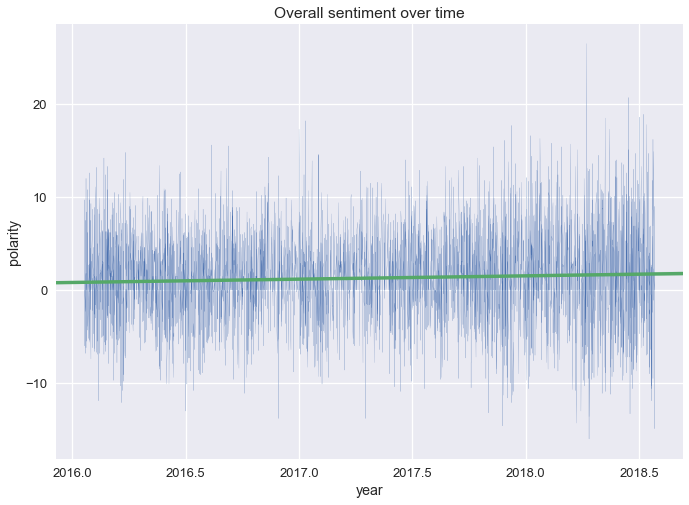

In [27]:
# Let's compare to Trump's overall sentiment over time
plt.figure(figsize=(10, 8))
plt.plot(trump.set_index('year').sort_index()['polarity'], linewidth=0.15)
sns.regplot(x='year', y='polarity', data=trump, scatter_kws={'s': 0})
plt.title('Overall sentiment over time');

#### Next, let's explore the bimodal nature of the 'fox' plot:

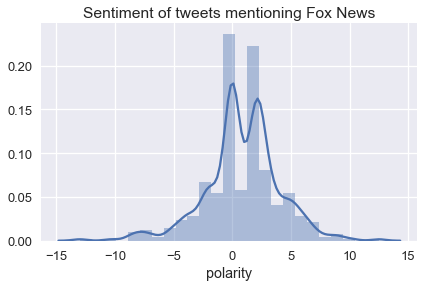

In [28]:
sns.distplot(fox['polarity'], bins=25)
plt.title('Sentiment of tweets mentioning Fox News');

In [29]:
first_peak = fox[(fox['polarity'] > -1.2) & (fox['polarity'] <= 0.1)]
second_peak = fox[(fox['polarity'] > 1.2) & (fox['polarity'] <= 2.5)]
between_peaks = fox[(fox['polarity'] > 0.1) & (fox['polarity'] <= 1.2)]
print(f'There are {len(first_peak)} tweets corresponding to '
      f'the first peak in the \'fox\' distplot and {len(second_peak)} '
      f'tweets corresponding to the second peak. Between the '
      f'two peaks there are only {len(between_peaks)} tweets.')

There are 107 tweets corresponding to the first peak in the 'fox' distplot and 98 tweets corresponding to the second peak. Between the two peaks there are only 25 tweets.


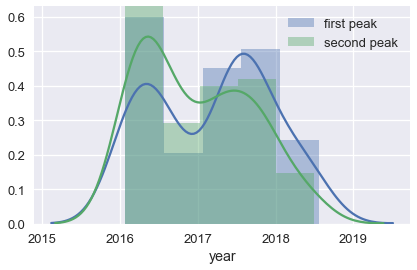

In [30]:
# Does this have anything to do with time?
sns.distplot(first_peak['year'], label='first peak')
sns.distplot(second_peak['year'], label='second peak')
plt.legend();

#### The tweets in 'first_peak' are slightly negative, with polarity in the range -1.2 to 0.1. The above plot shows that there are more of these as time goes on. Similarly, the tweets in 'second_peak' are somewhat positive, with polarity in the range 1.2 to 2.5. This plot also shows that there are fewer of these as time goes on. Perhaps this reflects an evolving relationship between Trump and Fox News?

### Next, we experiment with various factors that might be correlated with sentiment:

#### Does the number of words in a tweet correlate with polarity? Long rants, for instance:

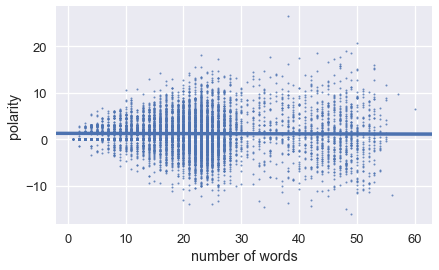

In [31]:
# Number of words vs polarity
sns.regplot(x=trump['text'].str.split().apply(len), y=trump['polarity'], scatter_kws={'s': 4})
plt.xlabel('number of words');

#### Doesn't seem so. Note that the seeming "break" in the graph at around 30 words is presumably due to Twitter's increasing the max number of characters in a tweet from 140 to 280 in Nov. 2017, after which point you could more easily fit additional words in a single tweet. Also note that there is a greater volatility in polarity with increasing number of words in a tweet.

#### Are negative tweets more retweeted than positive ones?

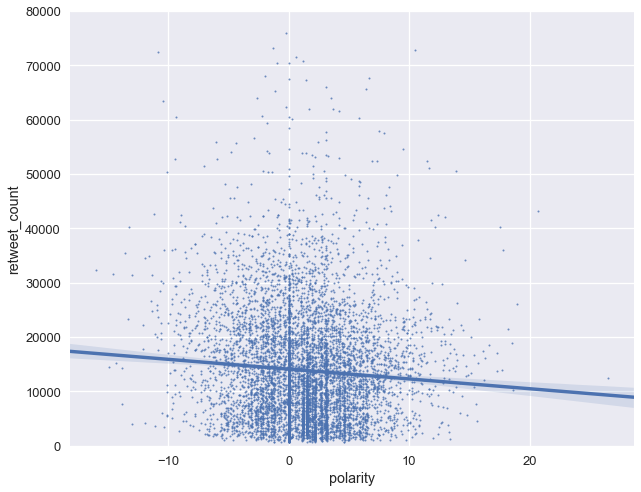

In [32]:
# Polarity vs retweet count
plt.figure(figsize=(9, 8))
sns.regplot(x='polarity', y='retweet_count', data=trump, scatter_kws={'s': 4});
plt.ylim(-20, 80000);

#### Yep, there seems to be a pretty solid relationship here, that more negative tweets are, on average, retweeted more than positive ones.

#### When Trump retweets someone else, do those tweets tend to be more or less positive than his own?

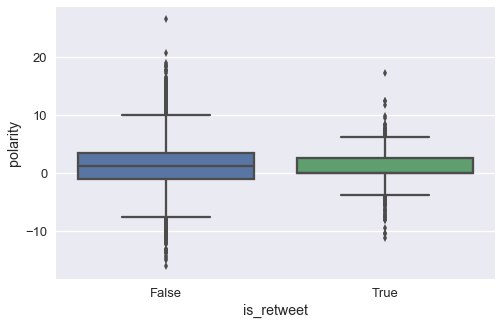

In [33]:
# Show distribution of polarity for retweets vs not-retweets
plt.figure(figsize=(7, 5))
sns.boxplot(x='is_retweet', y='polarity', data=trump);

#### Doesn't seem to be more positive or more negative, just less variable.

#### Does sentiment of tweet vary with time of day? Perhaps he's in a better mood earlier/later in the day?

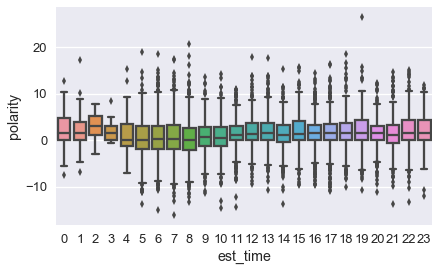

In [34]:
# How does sentiment correlate with time of day?
sns.boxplot(x=trump['est_time'].dt.hour, y=trump['polarity']);

#### No, it looks pretty constant from hour to hour.

### Finally, let's look at spikes in retweets. Do these correspond to world events?

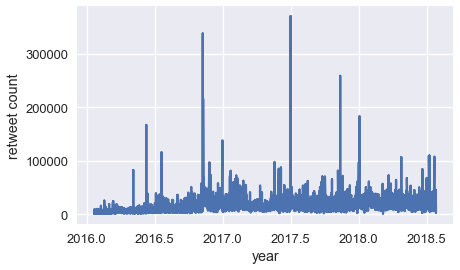

In [35]:
# Plot number of retweets over time
plt.plot(trump.set_index('year').sort_index()['retweet_count'])
plt.xlabel('year')
plt.ylabel('retweet count');

In [36]:
# Pick out the spikes in the above graph for inspection
retweet_spikes = (
    trump[(trump['retweet_count'] >= 100000) | 
          ((trump['retweet_count'] >= 75000) & (trump['year'] < 2016.5))]
)
retweet_spikes

,time,source,text,retweet_count,is_retweet,est_time,hour,year,no_punc,polarity
id,,,,,,,,,,
728297587418247168,2016-05-05 18:57:30,Twitter for iPhone,happy #cincodemayo! the best taco bowls are made in trump tower grill. i love hispanics! https://t.co/ufoteqd8ya https://t.co/k01mc6cudi,82444,False,2016-05-05 13:57:30-05:00,13.958333,2016.341530,happy cincodemayo the best taco bowls are made in trump tower grill i love hispanics https t co ufoteqd8ya https t co k01mc6cudi,9.1
741007091947556864,2016-06-09 20:40:32,Twitter for iPhone,"how long did it take your staff of 823 people to think that up--and where are your 33,000 emails that you deleted? https://t.co/geclntqizq",166748,False,2016-06-09 15:40:32-05:00,15.675556,2016.437158,how long did it take your staff of 823 people to think that up and where are your 33 000 emails that you deleted https t co geclntqizq,0.0
755788382618390529,2016-07-20 15:36:06,Twitter Web Client,the media is spending more time doing a forensic analysis of melania's speech than the fbi spent on hillary's emails.,115589,False,2016-07-20 10:36:06-05:00,10.601667,2016.549180,the media is spending more time doing a forensic analysis of melania s speech than the fbi spent on hillary s emails,0.0
795954831718498305,2016-11-08 11:43:14,Twitter for Android,today we make america great again!,337819,False,2016-11-08 06:43:14-05:00,6.720556,2016.852459,today we make america great again,3.1
796315640307060738,2016-11-09 11:36:58,Twitter for Android,such a beautiful and important evening! the forgotten man and woman will never be forgotten again. we will all come together as never before,215794,False,2016-11-09 06:36:58-05:00,6.616111,2016.855191,such a beautiful and important evening the forgotten man and woman will never be forgotten again we will all come together as never before,1.9
815185071317676033,2016-12-31 13:17:21,Twitter for Android,"happy new year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. love!",137964,False,2016-12-31 08:17:21-05:00,8.289167,2016.997268,happy new year to all including to my many enemies and those who have fought me and lost so badly they just don t know what to do love,-1.0
881503147168071680,2017-07-02 13:21:42,Twitter for iPhone,#fraudnewscnn #fnn https://t.co/wyunhjjujg,370272,False,2017-07-02 08:21:42-05:00,8.361667,2017.498630,fraudnewscnn fnn https t co wyunhjjujg,0.0
929511061954297857,2017-11-12 00:48:01,Twitter Web Client,"why would kim jong-un insult me by calling me ""old,"" when i would never call him ""short and fat?"" oh well, i try so hard to be his friend - and maybe someday that will happen!",258641,False,2017-11-11 19:48:01-05:00,19.800278,2017.863014,why would kim jong un insult me by calling me old when i would never call him short and fat oh well i try so hard to be his friend and maybe someday that will happen,0.6
948355557022420992,2018-01-03 00:49:19,Twitter for iPhone,"north korean leader kim jong un just stated that the “nuclear button is on his desk at all times.” will someone from his depleted and food starved regime please inform him that i too have a nuclear button, but it is a much bigger &amp; more powerful one than his, and my butto...",183436,False,2018-01-02 19:49:19-05:00,19.821944,2018.005479,north korean leader kim jong un just stated that the nuclear button is on his desk at all times will someone from his depleted and food starved regime please inform him that i too have a nuclear button but it is a much bigger amp more powerful one than his and my butto...,0.5


#### Scrolling through the above list, we see that some of these highly retweeted tweets are indeed about world events, e.g., Hilary's emails, election day '16 and the day after, his tiff with Kim Jong Un, and his threat against Iran.